In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
models = ["model2", "model3"]
pheno_cols = ['Child_ID_DD', 'Child_behav', 'Child_psych', 'Child_nervous_system', 'Child_congenital', 'Child_craniofacial']
variables = [
    ['Rare_Deleterious_SNVs', 'genes_del', 'genes_dup', 'STRs_exonic','SCZ_PRS'],
    ['Rare_Deleterious_SNVs_LOEUF', 'dels_loeuf', 'dups_loeuf', 'STRs_exonic_LOEUF035','SCZ_PRS']
    ]

In [42]:
def read_stats(store_dir, m, pc, v):
    filename = os.path.join(store_dir, "_".join([m, pc, v]) + ".tsv").replace("`", "")
    df = pd.read_csv(filename, sep="\t")
    lor, pval, r2 = df.loc[df.Variable==v, ["Log Odds Ratio", "P-value", "R2"]].values.flatten()
    return lor, pval, r2


def make_dataframe(store_dir, m, pcs, vs):
    data_dict = {
        "phenotypes": [],
        "variables": [],
        "log odds ratio": [],
        "p value": [],
        "R2": []
    }

    for pc in pcs:
        all_model_file = os.path.join(store_dir, "_".join([m, pc + ".tsv"]))
        all_model_df = pd.read_csv(all_model_file, sep="\t")
        data_dict["phenotypes"].append(pc)
        data_dict["variables"].append("all")
        data_dict["log odds ratio"].append(np.nan)
        data_dict["p value"].append(np.nan)
        data_dict["R2"].append(all_model_df.loc[0, "R2"])

        for v in vs:
            lor, pval, r2 = read_stats(store_dir, m, pc, v)
            data_dict["phenotypes"].append(pc)
            data_dict["variables"].append(v.upper())
            data_dict["log odds ratio"].append(lor)
            data_dict["p value"].append(pval)
            data_dict["R2"].append(r2)
    df = pd.DataFrame(data_dict)
    return df


def make_heatmaps(store_dir, ms, pcs, vs_list, save_file):
    fig, axes = plt.subplots(1, len(ms), figsize=(32, 10))
    for j,(m, vs) in enumerate(zip(ms, vs_list)):
        df = make_dataframe(store_dir, m, pcs, vs)
        plot_df = df.pivot(index="variables", columns="phenotypes", values="R2")
        annot_df = df.pivot(index="variables", columns="phenotypes", values="p value").fillna(1.)
        annot_df = (annot_df<0.05).replace({True: "*", False: ""})
        sns_ax = sns.heatmap(
            data=plot_df, 
            cmap="RdBu_r",
            # annot=annot_df,
            # annot_kws={"fontsize": 24},
            fmt='',
            square=True,
            cbar_kws={"shrink": 0.5},
            ax=axes[j],
            vmin=0.,
            vmax=0.2,
            )
        sns_ax.set_xticklabels(sns_ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        sns_ax.set_yticklabels(sns_ax.get_yticklabels(), rotation=0, horizontalalignment='right')
        sns_ax.set_title(f"{m}")
        sns_ax.set_xlabel("")
        sns_ax.set_ylabel("")

    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

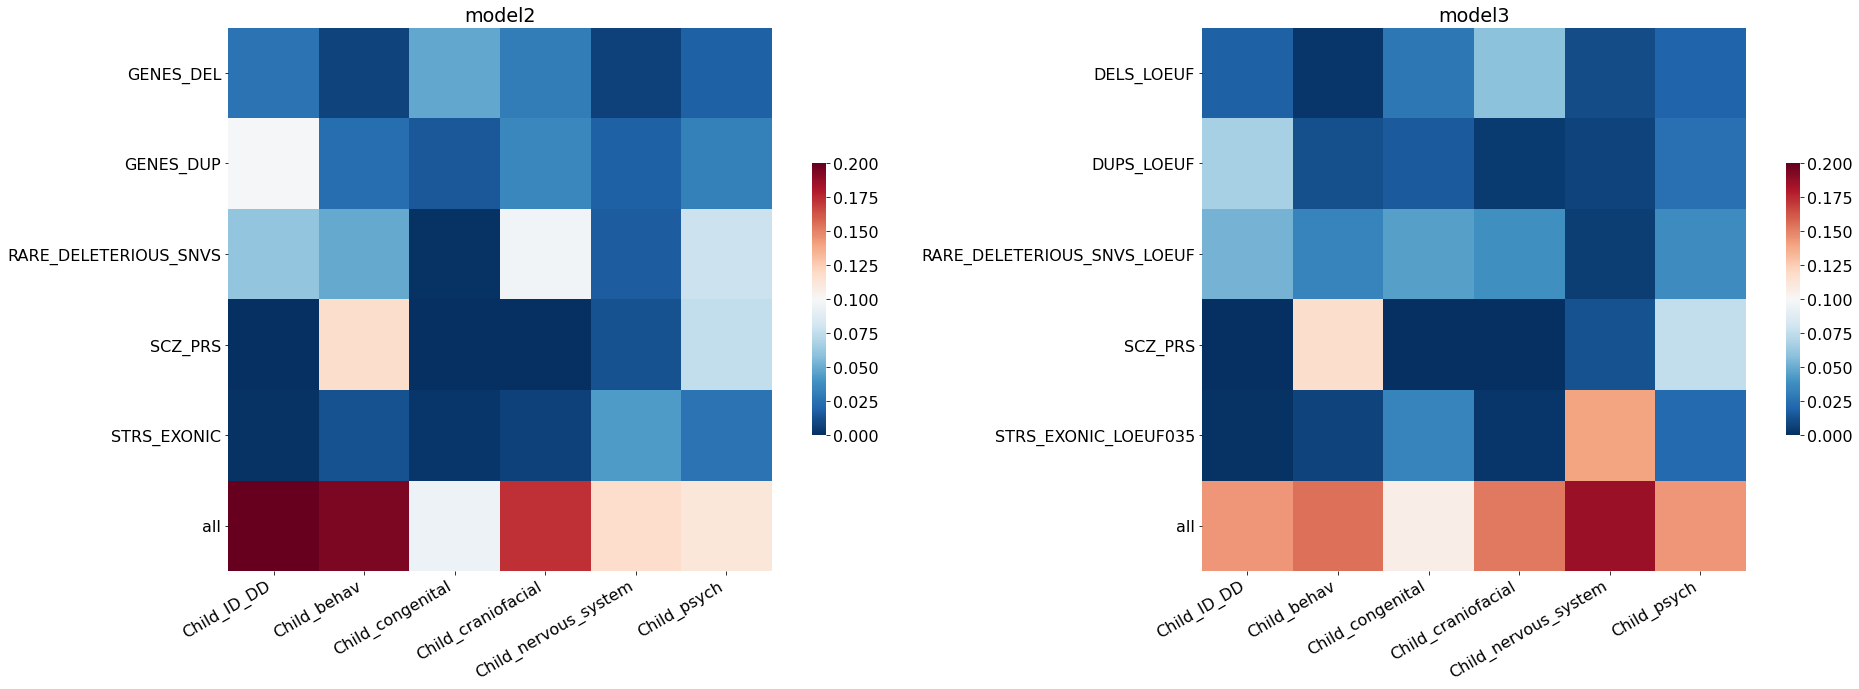

In [43]:
make_heatmaps("../data/statistics/", models, pheno_cols, variables, "../data/figures/model_heatmaps.pdf")